In [24]:
#export
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread,imsave
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter
from skimage import img_as_float
from scipy.ndimage.filters import convolve
from skimage import measure

In [27]:
#export
def detect_circles(img, radius, use_gradient=False, sigma=1.0, threshold=0.8, epsilon='auto', bin_scale=1, hough_output=False):
    
    # edge detection
    img_gray = img_as_float(rgb2gray(img))
    edges = canny(img_gray, sigma=sigma)
    
    #optional: calculate gradient
    if use_gradient:
        g_epsilon = 1e-10
        gradient_x = convolve(img_gray, np.array([[1,-1]]), mode='wrap')
        gradient_y = convolve(img_gray, np.array([[1],[-1]]), mode="wrap")
        gradient_x[gradient_x == 0] = g_epsilon
        gradient_direction = np.arctan(gradient_y / gradient_x)
    
    # hough circle detection
    fixed_radius = False
    if type(radius) is not list:
        fixed_radius = True
        radius = [radius, radius + 1]
    hough_shape_0 = radius[1] - radius[0]
    hough_shape_1 = int(img.shape[0] * bin_scale)
    hough_shape_2 = int(img.shape[1] * bin_scale)
    hough_cube = np.zeros((hough_shape_0, hough_shape_1, hough_shape_2))
    for rad in range(radius[0], radius[1]):
        hough_space = np.zeros((hough_shape_1, hough_shape_2))
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                if edges[row, col] != 0:
                    if not use_gradient:
                        if epsilon == 'auto':
                            theta_values = np.linspace(0, 2 * np.pi, 6 * rad)
                        else:
                            theta_values = np.arange(0, 2 * np.pi, epsilon)
                    else:
                        theta = gradient_direction[row, col]
                        theta_values = np.array([theta, theta-np.pi])
                    for theta in theta_values:
                        vote_x = int(round(col + rad * np.cos(theta)) * bin_scale)
                        vote_y = int(round(row + rad * np.sin(theta)) * bin_scale)
                        if vote_x >= 0 and vote_x < hough_space.shape[1] and vote_y >= 0 and vote_y < hough_space.shape[0]:
                            hough_space[vote_y, vote_x] = hough_space[vote_y, vote_x] + 1
        hough_cube[rad - radius[0]] = hough_space

        
    
    if fixed_radius:
        hough_space = hough_cube[0]
        centers = (np.transpose(np.array(np.where(hough_space >= hough_space.max() * threshold))) / bin_scale).astype(int)
        if not hough_output:
            return centers
        return centers, hough_space
    else:
        radius_centers = (np.transpose(np.array(np.where(hough_cube >= hough_cube.max() * threshold))) / bin_scale).astype(int)
        radius_centers[:, 0] = radius_centers[:, 0] + radius[0]
        if not hough_output:
            return radius_centers
        return radius_centers, hough_cube

option 0 - 6:1


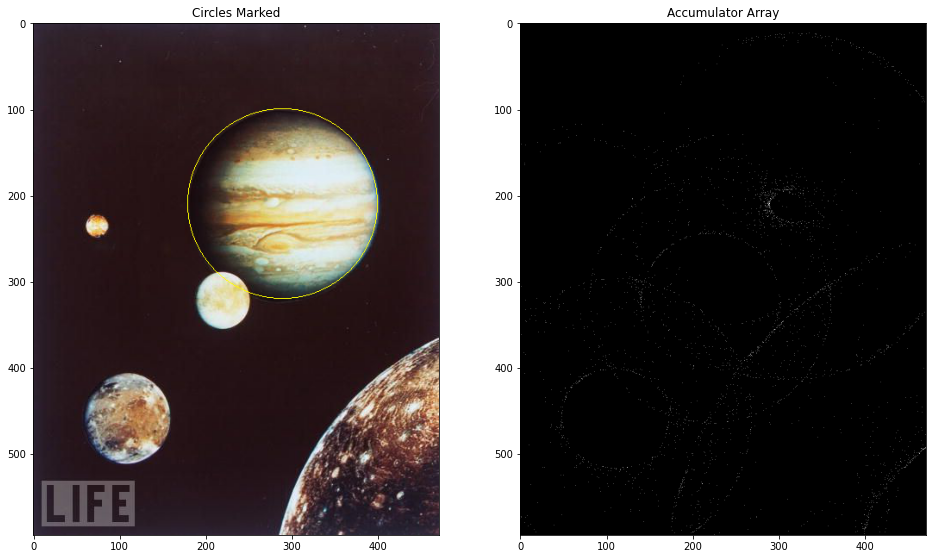

Circle Count: 1


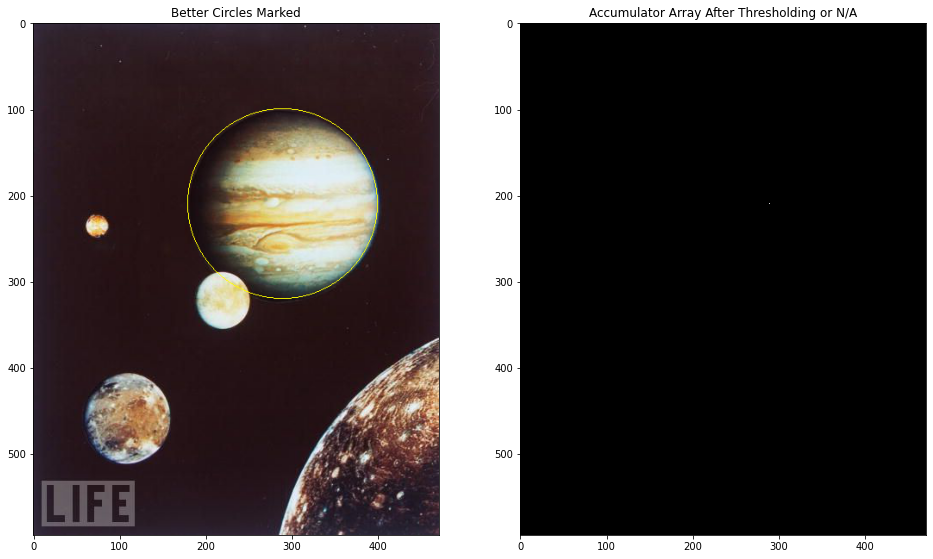

In [28]:
#export
if __name__ == '__main__':
    param_lists = [
        ['jupiter', 110, 6, 0.99, False, 1, .1],
        ['jupiter', 110, 6, 0.80, True, 1, .1],
        ['egg', 5, 3, 0.60, False, 1, 'auto'],           # use this for count
        ['egg', 5, 3, 0.70, True, 1, 'auto'],
        ['egg', 5, 3, 0.60, False, 0.5, 'auto'],
        ['egg', [2, 12], 2, 0.65, False, 1, .05],
        ['jupiter', [3, 110], 6, 0.80, True, 1.0, 0.1]
    ]
    
    egg_img = np.array(imread('./egg.jpg'))
    jupiter_img = np.array(imread('./jupiter.jpg'))

    # toggle for differnet image parameters
    param_i = int(input('option 0 - {}:'.format(len(param_lists) - 1)))

    img_name = param_lists[param_i][0]
    radius = param_lists[param_i][1]
    sigma = param_lists[param_i][2]
    threshold = param_lists[param_i][3]
    use_gradient = param_lists[param_i][4]
    bin_scale = param_lists[param_i][5]
    epsilon = param_lists[param_i][6]

    # image file name
    save_name_circled = '{}_circled{}_grad{}{}.jpg'.format(
        img_name,
        '_no' if not use_gradient else '',
        '_scale' if bin_scale != 1 else '',
        '_rad' if type(radius) is list else '' )
    save_name_hough = '{}_hough{}_grad{}.jpg'.format(
        img_name,
        '_no' if not use_gradient else '',
        '_scale' if bin_scale != 1 else '')
    if img_name == 'egg':
        img = egg_img.copy()
    elif img_name == 'jupiter':
        img = jupiter_img.copy()

    # marker color
    draw_color = np.array([255, 255, 0])

    centers, hough_space = detect_circles(img, radius, use_gradient=use_gradient, threshold=threshold, sigma=sigma, bin_scale=bin_scale, epsilon=epsilon, hough_output=True)
    if type(radius) is list:
        hough_img = hough_space.astype(int).sum(axis=0)
        scale_factor = 255 / hough_img.max()
        hough_img = (scale_factor * hough_img).astype(np.uint8)
    else:
        scale_factor = 255 / hough_space.max()
        hough_img = (scale_factor * hough_space).astype(np.uint8)

    circled_img = img.copy()
    for center in centers:
        if type(radius) is not list:
            circle = circle_perimeter(center[0], center[1], radius=radius, shape=img.shape)
        else:
            circle = circle_perimeter(center[1], center[2], radius=center[0], shape=img.shape)
        circled_img[circle] = draw_color
    imsave(save_name_circled, circled_img)
    if type(radius) is not list:
        imsave(save_name_hough, hough_img)

    plt.rcParams['figure.figsize'] = [16, 10]
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(circled_img)
    axs[1].imshow(hough_img, cmap='gray')
    axs[0].title.set_text('Circles Marked')
    axs[1].title.set_text('Accumulator Array')
    plt.show()
    
    if type(radius) is list:
        hough_img = hough_space
    hough_img_threshold = hough_img.copy()
    hough_img_threshold[hough_img < hough_img.max() * threshold] = 0
    hough_img_threshold[hough_img_threshold > 0] = 1
    hough_img_threshold = hough_img_threshold.astype(bool)

    labels = measure.label(hough_img_threshold, background=0)
    count = labels.max()
    # print(labels.shape)
    centers = []
    for i in range(1, count + 1):
        centers.append((np.mean(np.array(np.where(labels == i)), axis=1) / bin_scale).astype(int))
    centers = np.array(centers)

    circled_img = img.copy()
    for center in centers:
        # print(center)
        if type(radius) is list:
            circle = circle_perimeter(center[1], center[2], radius=center[0] + radius[0], shape=img.shape)
        else:
            circle = circle_perimeter(center[0], center[1], radius=radius, shape=img.shape)
        circled_img[circle] = draw_color
    imsave('reduced_' + save_name_circled, circled_img)

    print('Circle Count:', count)
    plt.rcParams['figure.figsize'] = [16, 10]
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(circled_img)
    if type(radius) is not list:
        axs[1].imshow(hough_img_threshold, cmap='gray')
    else:
        axs[1].imshow(circled_img)
    axs[0].title.set_text('Better Circles Marked')
    axs[1].title.set_text('Accumulator Array After Thresholding or N/A')
    plt.show()
    
    

In [ ]:
!python notebook2scriptCopy.py

Converted DetectCircles.ipynb to submissionDetectCircles.py
